In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

/opt/conda/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /opt/conda/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c106detail19maybe_wrap_dim_slowEllb
  warn(f"Failed to load image Python extension: {e}")


In [2]:
class FeatureVector(object):
    def __init__(self):
        self.model = models.resnet18(pretrained=True)
        self.model.eval()
        self.layer = self.model._modules.get("avgpool")
        self.cos = nn.CosineSimilarity(dim=1, eps=1e-6)
        self.transform_pipeline = transforms.Compose([transforms.Resize((224, 224)),
                                                      transforms.ToTensor(),
                                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                           std=[0.229, 0.224, 0.225])])
        
    def get_vector(self, img):
        t_img = Variable(self.transform_pipeline(img)).unsqueeze(0)
        feat_vec = torch.zeros(512)

        def copy_data(m, i, o):
            feat_vec.copy_(o.data.squeeze())

        h = self.layer.register_forward_hook(copy_data)
        self.model(t_img)
        h.remove()

        return feat_vec
    
    def similarity(self, a, b):
        return self.cos(a.unsqueeze(0), b.unsqueeze(0))

In [3]:
feat_vec = FeatureVector()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/jovyan/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:03<00:00, 12.3MB/s]


In [172]:
import os
path = "./images/"
image_filepaths = [path + x for x in os.listdir(path)]
image_filepaths

['./images/cat1.jpg',
 './images/cat2.jpg',
 './images/chair.jpg',
 './images/dog1.jpg',
 './images/dog2.jpg',
 './images/dog3.jpg',
 './images/dog4.jpg',
 './images/dog5.jpg',
 './images/person1.jpg',
 './images/person2.jpg',
 './images/stones.jpg']

In [173]:
image_file_name_path_mapping = { x.split("/")[-1]: x for x in image_filepaths}
image_file_name_path_mapping

{'cat1.jpg': './images/cat1.jpg',
 'cat2.jpg': './images/cat2.jpg',
 'chair.jpg': './images/chair.jpg',
 'dog1.jpg': './images/dog1.jpg',
 'dog2.jpg': './images/dog2.jpg',
 'dog3.jpg': './images/dog3.jpg',
 'dog4.jpg': './images/dog4.jpg',
 'dog5.jpg': './images/dog5.jpg',
 'person1.jpg': './images/person1.jpg',
 'person2.jpg': './images/person2.jpg',
 'stones.jpg': './images/stones.jpg'}

In [174]:
image_mappings = {x.split("/")[-1]:Image.open(x) for x in image_filepaths}
image_mappings

{'cat1.jpg': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x400>,
 'cat2.jpg': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2800x1575>,
 'chair.jpg': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=474x748>,
 'dog1.jpg': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1100x825>,
 'dog2.jpg': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=645x380>,
 'dog3.jpg': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2000x1333>,
 'dog4.jpg': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=474x316>,
 'dog5.jpg': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2560x1600>,
 'person1.jpg': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1280x720>,
 'person2.jpg': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1920x1080>,
 'stones.jpg': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x698>}

In [175]:
image_mappings.keys()

dict_keys(['cat1.jpg', 'cat2.jpg', 'chair.jpg', 'dog1.jpg', 'dog2.jpg', 'dog3.jpg', 'dog4.jpg', 'dog5.jpg', 'person1.jpg', 'person2.jpg', 'stones.jpg'])

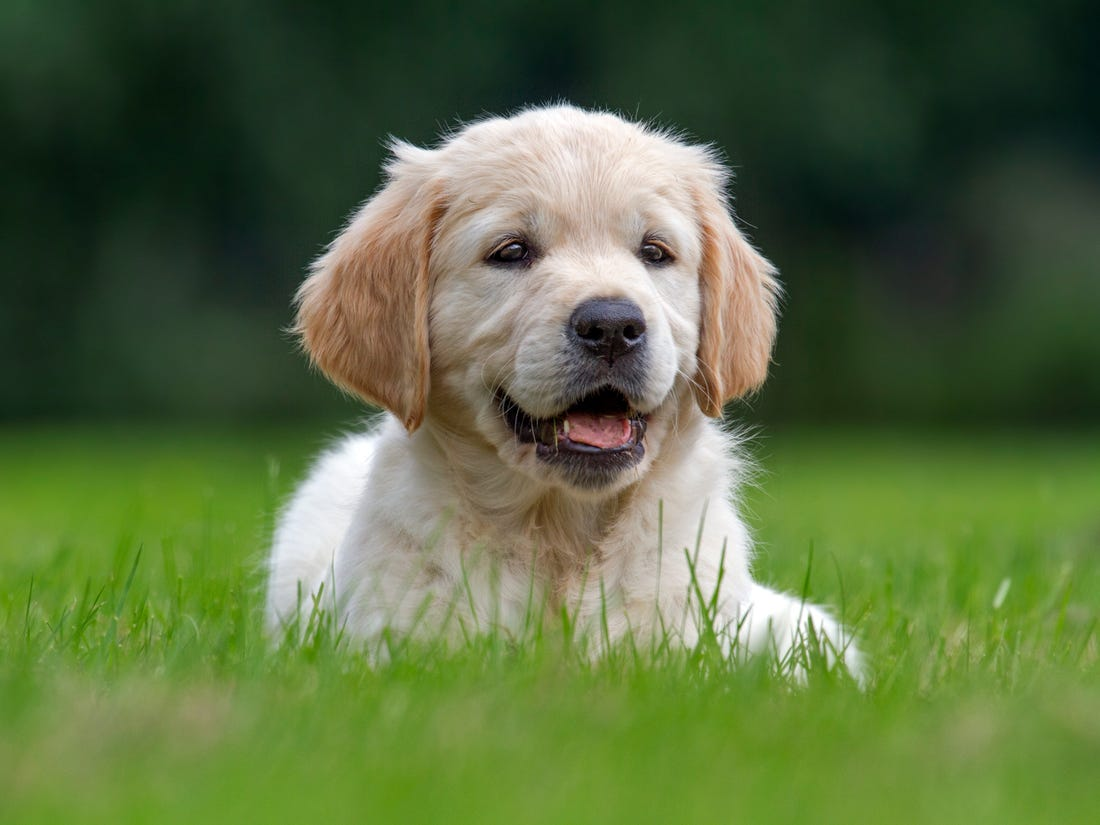

In [176]:
image_mappings['dog1.jpg']

In [177]:
def compare(a, b):
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(a)
    plt.subplot(1, 2, 2)
    plt.imshow(b)
    a_v = feat_vec.get_vector(a)
    b_v = feat_vec.get_vector(b)
    print('Similarity: {}'.format(feat_vec.similarity(a_v, b_v)))

Similarity: tensor([0.7975])


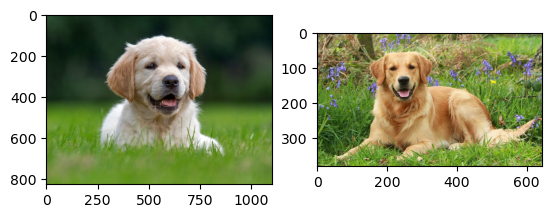

In [178]:
compare(image_mappings['dog1.jpg'], image_mappings['dog2.jpg'])

Similarity: tensor([0.5905])


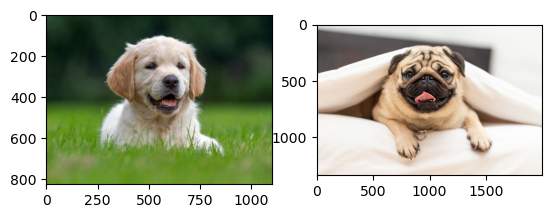

In [179]:
compare(image_mappings['dog1.jpg'], image_mappings['dog3.jpg'])

Similarity: tensor([0.4891])


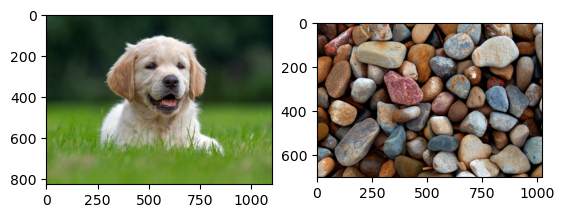

In [180]:
compare(image_mappings['dog1.jpg'], image_mappings['stones.jpg'])

Similarity: tensor([0.4682])


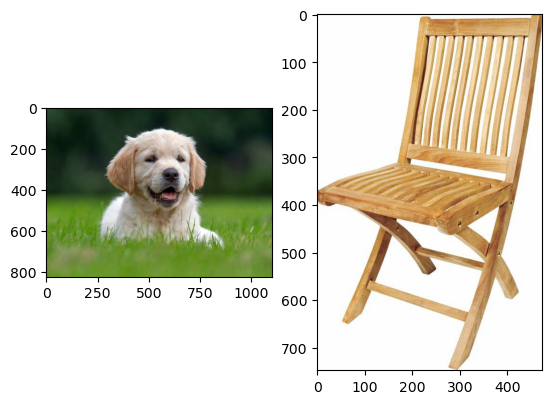

In [181]:
compare(image_mappings['dog1.jpg'], image_mappings['chair.jpg'])

Similarity: tensor([0.5276])


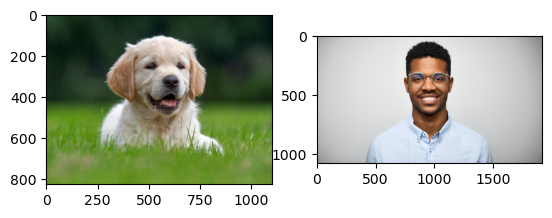

In [182]:
compare(image_mappings['dog1.jpg'], image_mappings['person2.jpg'])

Similarity: tensor([0.7823])


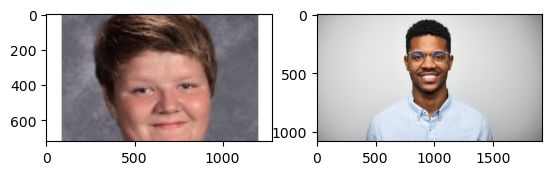

In [183]:
compare(image_mappings['person1.jpg'], image_mappings['person2.jpg'])

In [185]:
import weaviate

In [186]:
_HOST = "weaviate"
_PORT = "8080"
url = f"http://{_HOST}:{_PORT}"
client = weaviate.Client(url)
client.is_ready()

True

In [187]:
class_name = "Images"

In [188]:
client.schema.delete_all()

In [189]:
image_class_schema = {
    # name of the class
    "class": class_name,
    # a description of what this class represents
    "description": "An Image class to store the image paths and their vectors",
    # class properties
    "properties": [
        {
            "name": "path",
            "dataType": ["text"],
            "description": "stores the path of the image file", 
        },
        {
            "name": "name",
            "dataType": ["text"],
            "description": "stores the name of the image file", 
        },
        {
            "name": "uid",
            "dataType": ["text"],
            "description": "stores the unique id of the image file", 
        }
    ]
}

client.schema.create_class(image_class_schema)

In [190]:
import uuid

In [191]:


vector_mappings = {x:feat_vec.get_vector(image_mappings[x]).tolist() for x in image_mappings.keys()}



In [192]:
def generate_uuid(class_name: str, identifier: str,
                  test: str = 'teststrong') -> str:
    """ Generate a uuid based on an identifier
    :param identifier: characters used to generate the uuid
    :type identifier: str, required
    :param class_name: classname of the object to create a uuid for
    :type class_name: str, required
    """
    test = 'overwritten'
    return str(uuid.uuid5(uuid.NAMESPACE_DNS, class_name + identifier))

id_mappings = {x:generate_uuid(class_name,x) for x in image_mappings.keys()}


In [193]:
for img_name, img_vector in vector_mappings.items():
    data_obj = {
        "path": image_file_name_path_mapping[img_name],
        "name": img_name,
        "uid": id_mappings[img_name]
        }
    client.data_object.create(data_obj,
                              class_name,
                              id_mappings[img_name],
                              vector =img_vector,
                              )

In [194]:
lookup = {id_mappings[x]:image_mappings[x] for x in image_mappings.keys()}

for k in lookup:
    print(k, lookup[k])

bf6d7b0a-8a76-57b1-9c70-44ade454e253 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x400 at 0x7FDDC33353F0>
97596352-1652-528f-bf81-56af99afda94 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2800x1575 at 0x7FDDC3D2D360>
fc68b78d-5c84-59ea-ad16-06e5029874d7 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=474x748 at 0x7FDDC3D2FCD0>
bfd7a47b-14fb-50ab-950e-5c69219da882 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1100x825 at 0x7FDDD82877C0>
e7f39da2-5c4c-5900-87dd-0235579f7748 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=645x380 at 0x7FDDC33353C0>
38ffa705-bbdb-5696-b7a9-2d173fb53a9c <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2000x1333 at 0x7FDDC3A91090>
0c10e149-4820-5c10-ba55-2b8fbd2b6b05 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=474x316 at 0x7FDDC3A90100>
a349b210-b1da-5c35-99ab-40d50fdfad22 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2560x1600 at 0x7FDDC3A90F40>
667f6a6a-176c-5cb9-ba9b-9d13800b73ba <PIL

In [195]:
def process_query(vec):
    nearVector = {"vector": vec}
    res = client.query.get(class_name, ["name", "_additional {certainty}"]).with_near_vector(nearVector).do()
    print(res)
    print("------------------------------------------------------------------------------------------------")
    print("-----------------------------------Most similar text -------------------------------------------")
    print(res['data']['Get'][class_name][0]['name'])
    print("------------------------------------------------------------------------------------------------")
    return res

In [196]:
# client.query.get(class_name, ["name", "_additional {certainty}"]).with_near_vector(nearVector)

In [197]:
ref_img_for_comparison = 'dog1.jpg'
vec = vector_mappings[ref_img_for_comparison]
results = process_query(vec)

{'data': {'Get': {'Images': [{'_additional': {'certainty': 0.9999998807907104}, 'name': 'dog1.jpg'}, {'_additional': {'certainty': 0.8987709581851959}, 'name': 'dog2.jpg'}, {'_additional': {'certainty': 0.8952799439430237}, 'name': 'dog5.jpg'}, {'_additional': {'certainty': 0.832724392414093}, 'name': 'dog4.jpg'}, {'_additional': {'certainty': 0.7952567040920258}, 'name': 'dog3.jpg'}, {'_additional': {'certainty': 0.7695872783660889}, 'name': 'cat1.jpg'}, {'_additional': {'certainty': 0.7674388289451599}, 'name': 'person1.jpg'}, {'_additional': {'certainty': 0.7637968063354492}, 'name': 'person2.jpg'}, {'_additional': {'certainty': 0.7620337307453156}, 'name': 'cat2.jpg'}, {'_additional': {'certainty': 0.7445604801177979}, 'name': 'stones.jpg'}, {'_additional': {'certainty': 0.7341105937957764}, 'name': 'chair.jpg'}]}}}
------------------------------------------------------------------------------------------------
-----------------------------------Most similar text ------------------

In [198]:
results['data']['Get'][class_name]

[{'_additional': {'certainty': 0.9999998807907104}, 'name': 'dog1.jpg'},
 {'_additional': {'certainty': 0.8987709581851959}, 'name': 'dog2.jpg'},
 {'_additional': {'certainty': 0.8952799439430237}, 'name': 'dog5.jpg'},
 {'_additional': {'certainty': 0.832724392414093}, 'name': 'dog4.jpg'},
 {'_additional': {'certainty': 0.7952567040920258}, 'name': 'dog3.jpg'},
 {'_additional': {'certainty': 0.7695872783660889}, 'name': 'cat1.jpg'},
 {'_additional': {'certainty': 0.7674388289451599}, 'name': 'person1.jpg'},
 {'_additional': {'certainty': 0.7637968063354492}, 'name': 'person2.jpg'},
 {'_additional': {'certainty': 0.7620337307453156}, 'name': 'cat2.jpg'},
 {'_additional': {'certainty': 0.7445604801177979}, 'name': 'stones.jpg'},
 {'_additional': {'certainty': 0.7341105937957764}, 'name': 'chair.jpg'}]

Nearest neighbours and similarity in decreasing order
Similarity: 0.9999998807907104
Similarity: 0.8987709581851959
Similarity: 0.8952799439430237
Similarity: 0.832724392414093
Similarity: 0.7952567040920258
Similarity: 0.7695872783660889
Similarity: 0.7674388289451599
Similarity: 0.7637968063354492
Similarity: 0.7620337307453156
Similarity: 0.7445604801177979
Similarity: 0.7341105937957764


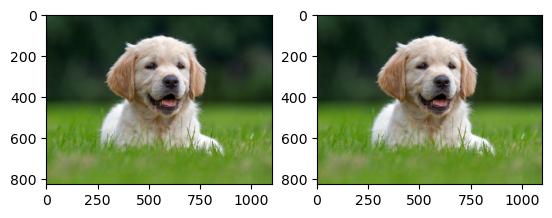

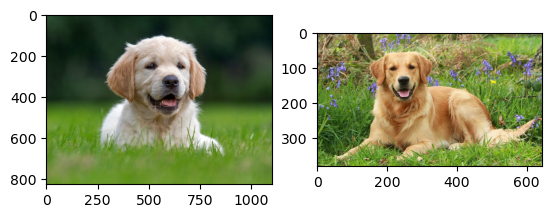

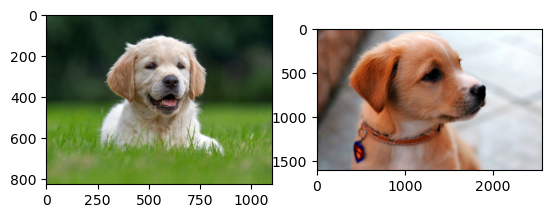

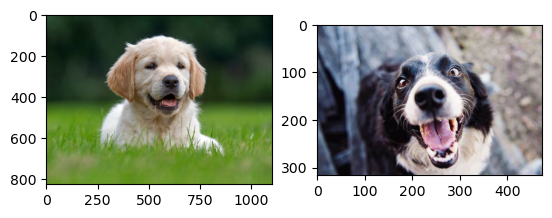

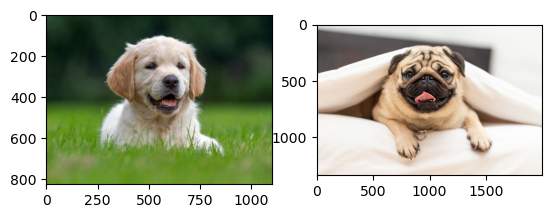

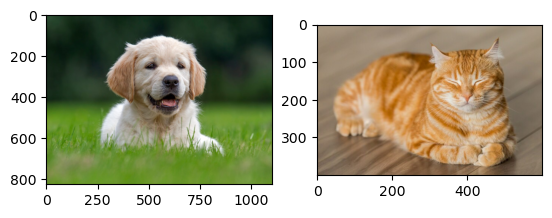

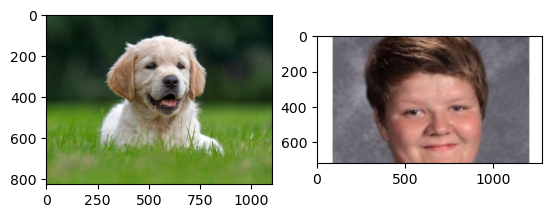

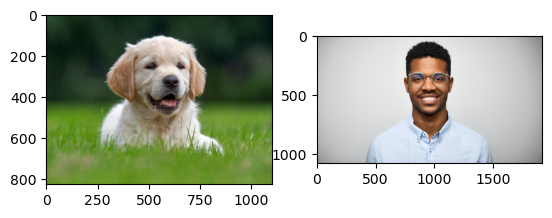

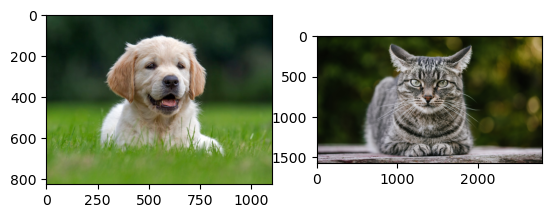

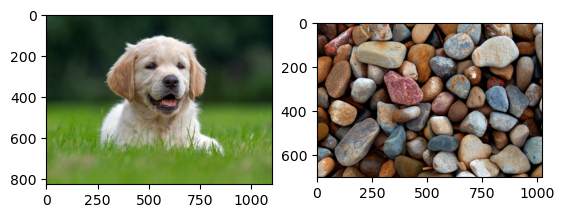

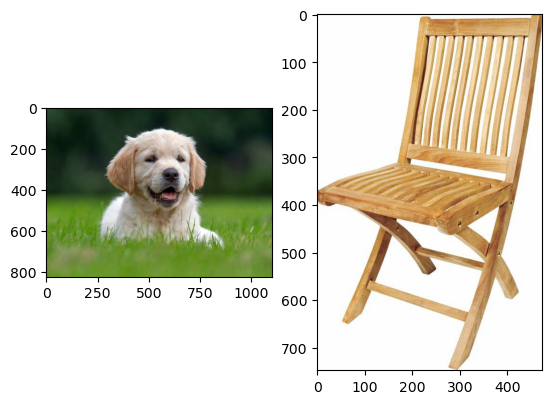

In [199]:
print("Nearest neighbours and similarity in decreasing order")

for neighbours in results['data']['Get'][class_name]:
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(image_mappings[ref_img_for_comparison])
    plt.subplot(1, 2, 2)
    plt.imshow(image_mappings[neighbours['name']])
    print('Similarity: {}'.format(neighbours['_additional']['certainty']))